In [32]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u



plt.rcParams['pdf.fonttype']=42
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# load session
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
mouse = 'SparseKO_02'
d = sparse_sessions[mouse][-2]
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']



pkldir = os.path.join('C://Users/esay/data/Stx3/YMazeSessPkls/', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)


In [51]:
trial_masks = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}
# channel_0_mask = sess.trial_info['block_number']%2==0
left_mask = sess.trial_info['LR']==-1
print(sess.trial_info['LR'],left_mask)


# trial_masks['channel_0_left'] = channel_0_mask*left_mask
# trial_masks['channel_0_right'] = channel_0_mask*(~left_mask)
# trial_masks['channel_1_left'] = (~channel_0_mask)*left_mask
# trial_masks['channel_1_right'] = (~channel_0_mask)*(~left_mask)

trial_masks['channel_0_left'] = left_mask
trial_masks['channel_0_right'] = (~left_mask)
trial_masks['channel_1_left'] = left_mask
trial_masks['channel_1_right'] = (~left_mask)

[-1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1. -1. -1.  1.
 -1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1.
 -1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.  1.
  1. -1.  1. -1. -1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.
  1. -1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1.] [ True  True  True False  True False  True  True  True  True  True False
 False False False  True  True False  True  True False  True  True False
 False False False False  True False  True False False False False False
  True  True False  True  True False  True False False  True  True  True
  True False False False  True False  True False  True  True  True  True
  True  True False  True  True False  True False False False  True False
 False  True False  True  True  True False  True False  True  True  True
 False False False False  True False False  True  True  True F

In [52]:
# pc mask

chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']

chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right

F = sess.timeseries['channel_1_spks']
F_chan1_mask = F[chan1_mask] 

F = sess.timeseries['channel_0_spks']
F_chan0_mask = F[chan0_mask]

In [9]:
def run_shuffle(F, trial_starts, teleports, t, rng):
    
    F_shuff = np.zeros_like(F)
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F = 1*F[:,start:stop]    
        _F = np.roll(_F,rng.integers(0,stop-start),axis=-1)
        F_shuff[:,start:stop] = 1*_F
        
    tmat = tpu.spatial_analyses.trial_matrix(F_shuff.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    return np.nanmean(tmat,axis=0)




In [53]:
# shuffle pc only 

rng = np.random.default_rng()

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}


F = F_chan0_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = F_chan0_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


F = F_chan1_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = F_chan1_mask
starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


In [5]:
# all cells

rng = np.random.default_rng()
nperms = 1000

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}

F = sess.timeseries['channel_0_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)

F = sess.timeseries['channel_0_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)


F = sess.timeseries['channel_1_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)

F = sess.timeseries['channel_1_F_dff_speed_filt']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)




(1000, 30, 331)
(1000, 30, 331)
(1000, 30, 234)
(1000, 30, 234)


In [35]:
# pc only 

trial_means = {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_left'], : , :][...,chan0_mask_pf_left]),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_right'], : , :][...,chan0_mask_pf_right]),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_left'], : , :][...,chan1_mask_pf_left]),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_right'], : , :][...,chan1_mask_pf_right]),
              }

IndexError: boolean index did not match indexed array along dimension 2; dimension is 270 but corresponding boolean dimension is 318

In [36]:
# all cells

trial_means = {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_right'], : , :], axis=0),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_right'], : , :],axis=0),
              }

In [54]:

shuff_results[mouse][5] = shuff_thresh

In [25]:
sess.novel_arm

-1

In [28]:
shuff_results[1]

KeyError: 1

In [29]:
def make_masks(sess):
    trial_masks = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}

    left_mask = sess.trial_info['LR']==-1
    print(sess.trial_info['LR'],left_mask)
    
    trial_masks['channel_0_left'] = left_mask
    trial_masks['channel_0_right'] = (~left_mask)
    trial_masks['channel_1_left'] = left_mask
    trial_masks['channel_1_right'] = (~left_mask)


    chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
    chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
    chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
    chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']
    
    chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
    chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right
    
    F = sess.timeseries['channel_1_spks']
    F_chan1_mask = F[chan1_mask] 
    
    F = sess.timeseries['channel_0_spks']
    F_chan0_mask = F[chan0_mask]

    return trial_masks, F_chan1_mask, F_chan1_mask

In [56]:
sess.trial_matrices.keys()

dict_keys(['channel_0_F_dff', 'bin_edges', 'bin_centers', 'channel_0_spks', 'channel_1_F_dff', 'channel_1_spks', 'licks', 'speed', 'channel_0_F_dff_speed_filt', 'channel_1_F_dff_speed_filt'])

In [57]:
trial_means[mouse][5]= {'channel_0_nov_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_fam_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_right'], : , :], axis=0),
               'channel_1_nov_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_fam_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_right'], : , :],axis=0),
              }

In [49]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice

# sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)
for mouse in sparse_mice[2:3]:
    print(mouse)
    shuff_results[mouse] = {}
    trial_means[mouse] = {}
    for day in range(6):
        shuff_results[mouse][day] = {}
        trial_means[mouse][day] = {}

        sess = u.load_single_day(mouse, day)
        trial_masks, F_chan1_mask, F_chan1_mask = make_masks(sess)


        rng = np.random.default_rng()

        shuff_thresh = {'channel_0_left': None,
                       'channel_0_right': None,
                       'channel_1_left': None,
                       'channel_1_right': None}
        
        F = F_chan0_mask
        starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F = F_chan0_mask
        starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        
        F = F_chan1_mask
        starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)
        
        F = F_chan1_mask
        starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
        shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
        shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

        shuff_results[mouse][day] = shuff_thresh # save to shuff_results

        if sess.novel_arm == -1:
            trial_means[mouse][day]= {'channel_0_nov_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_fam_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_right'], : , :], axis=0),
               'channel_1_nov_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_fam_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_right'], : , :],axis=0),
              }
        elif sess.novel_arm == 1:
            trial_means[mouse][day] = {'channel_0_fam_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_nov_mean': np.nanmean(sess.trial_matrices['channel_0_F_dff_speed_filt'][trial_masks['channel_0_right'], : , :], axis=0),
               'channel_1_fam_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_nov_mean': np.nanmean(sess.trial_matrices['channel_1_F_dff_speed_filt'][trial_masks['channel_1_right'], : , :],axis=0),
              }


SparseKO_03
{'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 17, 'novel_arm': 1, 'exp_day': 1}
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1.
 -1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1.  1.
  1.  1.  1.  1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.] [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  Tru

In [62]:
shuff_results.keys()

dict_keys(['SparseKO_02', 'SparseKO_05', 'SparseKO_03'])

In [70]:
import pickle 
with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_results.pkl','wb') as file:
        pickle.dump(shuff_results,file)

In [9]:
field_info = {'channel_0_left': [],
               'channel_0_right': [],
               'channel_1_left': [],
               'channel_1_right': []}

for k, thresh in shuff_thresh.items():
    print(k, thresh.shape)
    sig_bins = trial_means[k]>thresh

    # eliminate fields that start at first bin of track or end at last bin of track
    

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        # print(_redge.size)
        if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15) and (_ledge[0]>0) and ((_redge[0][0]+_ledge[0])<29):
        # if (_redge.shape[0]>0):
        # if (_redge.shape[0]>0):
            field_info[k].append([_ledge[1], _ledge[0], _redge[0][0]])
        

            # fig, ax = plt.subplots()
            # ax.plot(trial_means[k][:,_ledge[1]
            # if 'channel_0' in k:
            #     ax.imshow(sess.trial_matrices['channel_0_F_dff'][trial_masks[k],:, _ledge[1]])
            #     ax.plot(_ledge[0]*np.ones([2,]), [0, trial_masks[k].sum()], color='red')
            #     ax.plot((_ledge[0]+_redge[0][0])*np.ones([2,]), [0, trial_masks[k].sum()], color='red')
            # else:
            #     ax.imshow(sess.trial_matrices['channel_1_F_dff'][trial_masks[k],:, _ledge[1]])
            #     ax.plot(_ledge[0]*np.ones([2,]), [0, trial_masks[k].sum()], color='red')
            #     ax.plot((_ledge[0]+_redge[0][0])*np.ones([2,]), [0, trial_masks[k].sum()], color='red')
            # print(trial_means[k].shape)
        # ax.imshow(trial_means[k][:,_ledge[1]])

for k,v in field_info.items():
    field_info[k]=np.array(v)

channel_0_left (30, 296)
channel_0_right (30, 296)
channel_1_left (30, 201)
channel_1_right (30, 201)


(array([0.55223881, 0.32835821, 0.11940299, 0.        ]),
 array([1., 2., 3., 4., 5.]),
 <BarContainer object of 4 artists>)

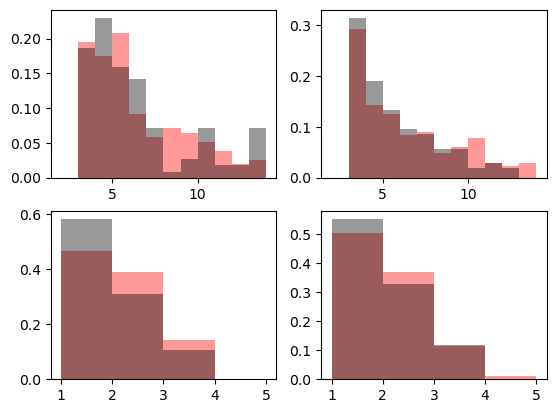

In [10]:
fig, ax = plt.subplots(2,2)

width_bins = np.arange(2,15)
field_bins = np.arange(1,6)
##
fi = field_info['channel_0_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)

##
fi = field_info['channel_1_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)

##
fi = field_info['channel_0_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)


##
fi = field_info['channel_1_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)


    